In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import umap
import umap.plot
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from pathlib import Path

In [37]:
print(f"""pandas version: {pd.__version__}
numpy version: {np.__version__}
seaborn version: {sns.__version__}
umap version: {umap.__version__}
""".format())

pandas version: 1.5.3
numpy version: 1.23.5
seaborn version: 0.13.1
umap version: 0.5.4



When we were exploring the splicing defects in Speckle-depleted or Speckle-disturbed cells, we noticed that a very specific subset of introns were effect: GC-rich short introns surrounding GC-rich exons. When we plot these introns on a scatterplot where the x-axis represents log-transformed length of the introns and the y-axis representing GC-content, these introns would occupy the top left corner. In contrast, depleting TRA2A/B affects introns that long and GC-poor. Overall it seems like human introns explore a large GC-intron length space, but also with clear restrictions: there are few/no GC-rich introns that are also long.

Simply looking at the log(length) vs GC plots of well-studied model systems is enough to see that this intron organisation is not universal. We wondered whether we can summarise this obsvervation for all the organisms that have a genome annotation at NCBI. In this notebook we try to do this by converting theses plots into 30x30 2D dataframes where each bin represents the frequency of introns in a given bin (e.g. 50-53% GC, 1-2kb). These dataframes are then used to construct a UMAP which can place similar-looking matrices with each other. The goal is to see if there are general trends that make sense with taxonomic information or not. The null hypothesis is that introns are more or less evolving freely and these distributions do not fit into clear patterns.

To to this:

Run the scripts that download all genome fasta files and gene annotations. These scripts also create csv files which contain all non-redundant introns and exons of protein-coding genes, abd their coordinates which are used to calculate GC content. [Pre-computed files available here: ]
Load these files to create the 2D matrices (or plots). [Pre-computed matrices here:]
Create the UMAP

In [25]:
# If running eveything from scratch, this is the folder that contains necessary 
# dataframes from each species
# Can be generated by running the scripts {}

DATA_FRAMES_FOLDER = "/project/bigdata_aktas/genomes/ncbi_gc/data_frames" 

def process_files(genome_dataframe, DATA_FRAMES_FOLDER, bins=30):
    plt.ioff() # do not print the plot to console
    
    taxid_2D_values = dict()
    
    for index, row in genome_dataframe.iterrows():
        parameters = (row['#assembly_accession'], 
              '_'.join(row['organism_name'].split()), 
              row['group'], 
             row['ftp_path'],
            row['taxid'])
        
        assembly_name, organism_name, group, ftp_path, taxid = parameters

        intron_out = f"{DATA_FRAMES_FOLDER}/{group}/introns/{organism_name}_{assembly_name}_introns.csv.gz"
        if os.path.isfile(intron_out):
            introns_bf = pd.read_csv(intron_out)
            introns_bf['intron_length_log'] = np.log10(introns_bf.intron_length)
            
            values = plt.hist2d(introns_bf.intron_length_log, 
                                introns_bf.GC, 
                                density=False,
                                range=[[1,6],[0,1]],
                                bins=bins)
            plt.close()
            
            taxid_2D_values[taxid] = values[0].flatten()
        else:
            print(f'Skipping:\t{group}, {organism_name}, intron output missing')
    return taxid_2D_values

In [26]:
def generate_genome_dataframes(use_archived=True):
    vertebrate_mammalian_path = Path("data/pre-processed/vertebrate_mammalian.csv.gz")
    vertebrate_other_path = Path("vertebrate_other.csv.gz")
    invertebrate_path = Path("invertebrate.csv.gz")
    plant_path = Path("plant.csv.gz")
    fungi_path = Path("fungi.csv.gz")

    paths_exist = (vertebrate_mammalian_path.exists() 
                   and vertebrate_other_path.exists() 
                   and invertebrate_path.exists() 
                   and plant_path.exists() 
                   and fungi_path.exists()
                  )

    if use_archived and paths_exist:
        vertebrate_mammalian = pd.read_csv("/project/bigdata_aktas/genomes/ncbi_gc/genomes_info_archive/2025-10-01/vertebrate_mammalian.csv.gz")
        vertebrate_other = pd.read_csv("/project/bigdata_aktas/genomes/ncbi_gc/genomes_info_archive/2025-10-01/vertebrate_other.csv.gz")
        invertebrate = pd.read_csv("/project/bigdata_aktas/genomes/ncbi_gc/genomes_info_archive/2025-10-01/invertebrate.csv.gz")
        plant = pd.read_csv("/project/bigdata_aktas/genomes/ncbi_gc/genomes_info_archive/2025-10-01/plant.csv.gz")
        fungi = pd.read_csv("/project/bigdata_aktas/genomes/ncbi_gc/genomes_info_archive/2025-10-01/fungi.csv.gz")
    
    else: #directly loaded from NCBI
        vertebrate_mammalian_direct = "https://ftp.ncbi.nlm.nih.gov/genomes/refseq/vertebrate_mammalian/assembly_summary.txt"
        vertebrate_other_direct = "https://ftp.ncbi.nlm.nih.gov/genomes/refseq/vertebrate_other/assembly_summary.txt"
        invertebrate_direct = "https://ftp.ncbi.nlm.nih.gov/genomes/refseq/invertebrate/assembly_summary.txt"
        plant_direct = "https://ftp.ncbi.nlm.nih.gov/genomes/refseq/plant/assembly_summary.txt"
        fungi_direct = "https://ftp.ncbi.nlm.nih.gov/genomes/refseq/fungi/assembly_summary.txt"
        
        vertebrate_mammalian = pd.read_csv(vertebrate_mammalian_direct, sep="\t", skiprows=1)
        vertebrate_other = pd.read_csv(vertebrate_other_direct, sep="\t", skiprows=1)
        invertebrate = pd.read_csv(invertebrate_direct, sep="\t", skiprows=1)
        plant = pd.read_csv(plant_direct, sep="\t", skiprows=1)
        fungi = pd.read_csv(fungi_direct, sep="\t", skiprows=1)
        
    vertebrate_mammalian['group'] = 'vertebrate_mammalian'
    vertebrate_other['group'] = 'vertebrate_other'
    invertebrate['group'] = 'invertebrate'
    plant['group'] = 'plant'
    fungi['group'] = 'fungi'
    
    taxid_organism_name = pd.concat([vertebrate_mammalian[['taxid', 'organism_name', '#assembly_accession', 'group']], 
               vertebrate_other[['taxid', 'organism_name', '#assembly_accession', 'group']],
               invertebrate[['taxid', 'organism_name', '#assembly_accession', 'group']],
               plant[['taxid', 'organism_name', '#assembly_accession', 'group']],
               fungi[['taxid', 'organism_name', '#assembly_accession', 'group']]
              ]
             ).drop_duplicates('taxid')
    
    taxid_organism_name

    return vertebrate_mammalian, vertebrate_other, invertebrate, plant, fungi, taxid_organism_name

In [27]:
def generate_taxid_2D_merged():
    vertebrate_mammalian, vertebrate_other, invertebrate, plant, fungi, taxid_organism_name = generate_genome_dataframes()
    
    taxid_2D_values_mammalian = process_files(vertebrate_mammalian.drop_duplicates('taxid'), bins=30)
    taxid_2D_values_vertebrate = process_files(vertebrate_other.drop_duplicates('taxid'), bins=30)
    taxid_2D_values_invertebrate = process_files(invertebrate.drop_duplicates('taxid'), bins=30)
    taxid_2D_values_plant = process_files(plant.drop_duplicates('taxid'), bins=30)
    taxid_2D_values_fungi = process_files(fungi.drop_duplicates('taxid'), bins=30)
    
    taxid_2D_values_mammalian_df = pd.DataFrame.from_dict(taxid_2D_values_mammalian).T
    taxid_2D_values_vertebrate_df = pd.DataFrame.from_dict(taxid_2D_values_vertebrate).T
    taxid_2D_values_invertebrate_df = pd.DataFrame.from_dict(taxid_2D_values_invertebrate).T
    taxid_2D_values_plant_df = pd.DataFrame.from_dict(taxid_2D_values_plant).T
    taxid_2D_values_fungi_df = pd.DataFrame.from_dict(taxid_2D_values_fungi).T
    
    taxid_2D_merged = pd.concat([taxid_2D_values_mammalian_df,
                                 taxid_2D_values_vertebrate_df, 
                                taxid_2D_values_invertebrate_df,
                                taxid_2D_values_plant_df,
                                taxid_2D_values_fungi_df])
    return taxid_2D_merged

In [28]:
# To reproduce the UMAP in the manuscript, load the pre-calculated matrix
# To run it from scratch set the path below to nothing

PATH_TO_taxid_2D_merged_pickle = Path("data/pre-processed/taxid_2D_merged.pkl.gz", compression='gzip')

if PATH_TO_taxid_2D_merged_pickle.exists():
    taxid_2D_merged = pd.read_pickle(PATH_TO_taxid_2D_merged_pickle)
else:
    taxid_2D_merged = generate_taxid_2D_merged()

In [29]:
# I'm removing salmonids, they have a very unique intron distribution
# which creates a tiny island of it's own away from everybody else, squishing the rest of the UMAP
# skip this cell to create UMAP with salmonids

salmonids = """74940
8017
8022
90313
8032
8019
8038
59861
2691554
8023
8030
8040
8018""".split()

salmonids = [int(x) for x in salmonids]

taxid_2D_merged = taxid_2D_merged[~taxid_2D_merged.index.isin(salmonids)]

In [30]:
# Matrices contain raw counts, we normalize these values with the min_max_scaler function so all values are between 0-1

min_max_scaler = MinMaxScaler()

taxid_2D_merged_min_max_scaled = min_max_scaler.fit_transform(taxid_2D_merged)

In [31]:
# Generate the embedding for UMAP
taxid_2D_merged_min_max_scaled_embedding = umap.UMAP(min_dist=0.1, 
                                             n_neighbors=15, 
                                             random_state=42).fit(taxid_2D_merged_min_max_scaled)

/home/ilik/anaconda33/envs/bioframe/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [32]:
# Load taxonomy info, generated with ETE3
PATH_TO_TAX = Path("data/pre-processed/taxonomy_info.csv.gz")
taxonomy_info = pd.read_csv(PATH_TO_TAX)

# Comment this if salmonids are included above
taxonomy_info = taxonomy_info[~(taxonomy_info.taxid.isin(salmonids))]

## Figure 6D

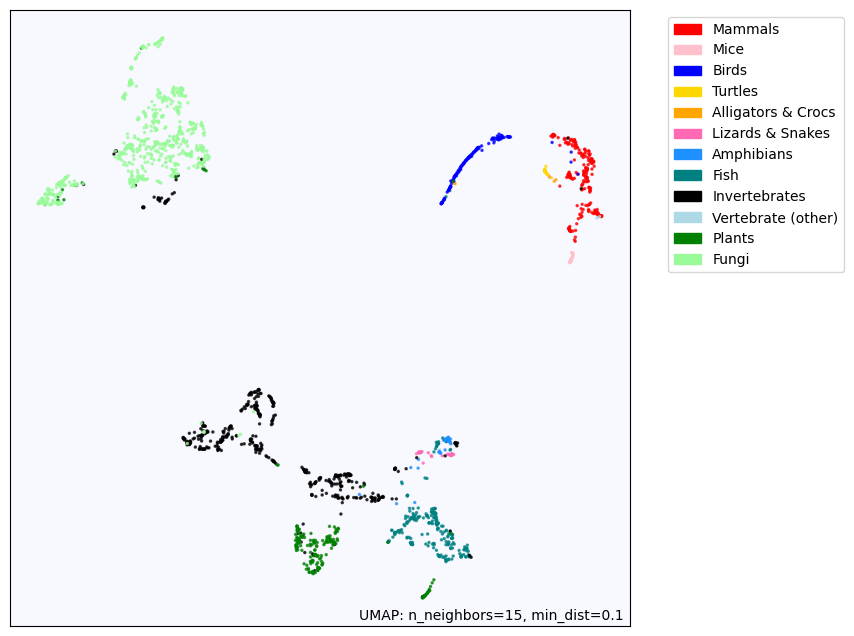

In [33]:
# Plot

color_dict={
    "Mammals":"red",
    "Mice":"pink",
    "Birds":"blue",
    "Turtles":"gold",
    "Alligators & Crocs":"orange",
    "Lizards & Snakes":"hotpink",
    "Amphibians":"dodgerblue",
    "Fish":"teal",
    "Invertebrates":"black",
    "Vertebrate (other)":"lightblue",
    "Plants":"green",
    "Fungi":"palegreen"
           }

umap.plot.points(taxid_2D_merged_min_max_scaled_embedding,
                labels=taxonomy_info[['taxid', 'cats']].set_index('taxid').cats,
                color_key=color_dict,
                alpha=0.7,
                background="ghostwhite",
                width=800,
                height=800)
patches = [mpatches.Patch(color=v, label=k) for k,v in color_dict.items()]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
plt.close()